Data can be found here: https://www.kaggle.com/datasets/uciml/faulty-steel-plates

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
import umap
from mpl_toolkits.mplot3d import Axes3D 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.optimizers import Adam
from scipy.special import softmax
import warnings
warnings.filterwarnings('ignore')


2024-12-06 11:26:14.214235: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733480774.234816   58478 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733480774.240439   58478 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-06 11:26:14.260615: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


load and display the dataset

In [2]:
df = pd.read_csv('faults.csv')
df.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0


General infos

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              1941 non-null   int64  
 1   X_Maximum              1941 non-null   int64  
 2   Y_Minimum              1941 non-null   int64  
 3   Y_Maximum              1941 non-null   int64  
 4   Pixels_Areas           1941 non-null   int64  
 5   X_Perimeter            1941 non-null   int64  
 6   Y_Perimeter            1941 non-null   int64  
 7   Sum_of_Luminosity      1941 non-null   int64  
 8   Minimum_of_Luminosity  1941 non-null   int64  
 9   Maximum_of_Luminosity  1941 non-null   int64  
 10  Length_of_Conveyer     1941 non-null   int64  
 11  TypeOfSteel_A300       1941 non-null   int64  
 12  TypeOfSteel_A400       1941 non-null   int64  
 13  Steel_Plate_Thickness  1941 non-null   int64  
 14  Edges_Index            1941 non-null   float64
 15  Empt

In [4]:
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} features, while having {df.isnull().sum().sum()} null values.')
print(f'Features have data type {df.dtypes.unique()[0]} and {df.dtypes.unique()[1]}.')

The dataset has 1941 rows and 34 features, while having 0 null values.
Features have data type int64 and float64.


Statistics about the features

In [5]:
#df_OHE = df[['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']]
df.drop(['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults'], axis = 1).describe().T

,count,mean,std,min,25%,50%,75%,max
X_Minimum,1941.0,5.711360e+02,5.206907e+02,0.0000,51.0000,4.350000e+02,1.053000e+03,1.705000e+03
X_Maximum,1941.0,6.179645e+02,4.976274e+02,4.0000,192.0000,4.670000e+02,1.072000e+03,1.713000e+03
Y_Minimum,1941.0,1.650685e+06,1.774578e+06,6712.0000,471253.0000,1.204128e+06,2.183073e+06,1.298766e+07
Y_Maximum,1941.0,1.650739e+06,1.774590e+06,6724.0000,471281.0000,1.204136e+06,2.183084e+06,1.298769e+07
Pixels_Areas,1941.0,1.893878e+03,5.168460e+03,2.0000,84.0000,1.740000e+02,8.220000e+02,1.526550e+05
X_Perimeter,1941.0,1.118552e+02,3.012092e+02,2.0000,15.0000,2.600000e+01,8.400000e+01,1.044900e+04
Y_Perimeter,1941.0,8.296600e+01,4.264829e+02,1.0000,13.0000,2.500000e+01,8.300000e+01,1.815200e+04
Sum_of_Luminosity,1941.0,2.063121e+05,5.122936e+05,250.0000,9522.0000,1.920200e+04,8.301100e+04,1.159141e+07
Minimum_of_Luminosity,1941.0,8.454869e+01,3.213428e+01,0.0000,63.0000,9.000000e+01,1.060000e+02,2.030000e+02
Maximum_of_Luminosity,1941.0,1.301937e+02,1.869099e+01,37.0000,124.0000,1.270000e+02,1.400000e+02,2.530000e+02


Lower the name of the columns

In [6]:
df.columns = map(str.lower, df.columns)

Create a column encoding the anomalies features; this is wrong from a model point of view, but it's useful for exploratory analysis. It will be dropped in the future


In [7]:
# list of the anomalies features present in the dataset
target_cols = ['pastry', 'z_scratch', 'k_scatch', 'stains', 'dirtiness', 'bumps', 'other_faults'] 
# list of the features of the steel plates
feat_col = ['x_minimum', 'x_maximum', 'y_minimum', 'y_maximum', 'pixels_areas', 'x_perimeter', 'y_perimeter', 'sum_of_luminosity', 'minimum_of_luminosity', 'maximum_of_luminosity', 'length_of_conveyer', 'typeofsteel_a300', 'typeofsteel_a400', 'steel_plate_thickness', 'edges_index', 'empty_index', 'square_index', 'outside_x_index', 'edges_x_index', 'edges_y_index', 'outside_global_index', 'logofareas', 'log_x_index', 'log_y_index', 'orientation_index', 'luminosity_index', 'sigmoidofareas'] 

In [8]:
enc_dict = {'pastry' : 0, 
            'z_scratch' : 1,
            'k_scatch' : 2, 
            'stains' : 3,
            'dirtiness' : 4, 
            'bumps' : 5, 
            'other_faults' : 6} # mapper for the encoding

df['anomaly'] = pd.from_dummies(df[target_cols]).replace(enc_dict)

Display how the anomalies are divided in the dataset

In [9]:
anomaly_count = pd.DataFrame(df['anomaly'].value_counts()).sort_index()
anomaly_count.index = target_cols
anomaly_count

,count
pastry,158
z_scratch,190
k_scatch,391
stains,72
dirtiness,55
bumps,402
other_faults,673


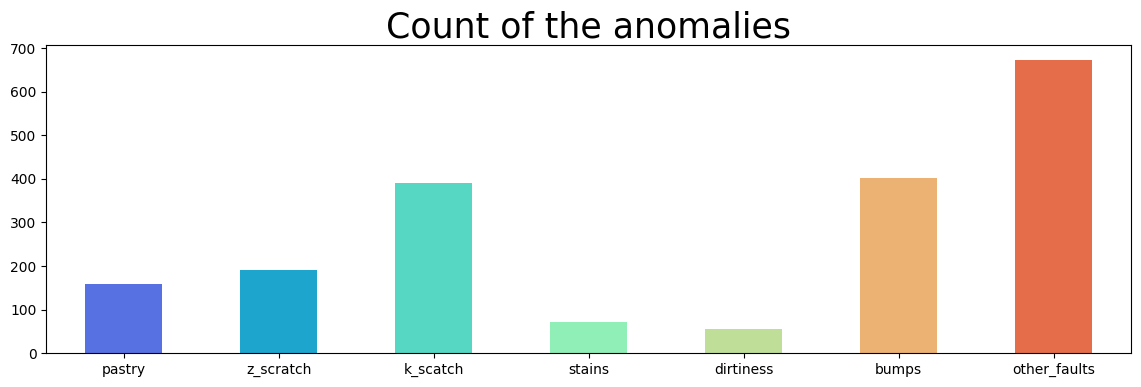

In [10]:
plt.figure(figsize = (14, 4))
sns.barplot(anomaly_count, x = anomaly_count.index, y = 'count', hue = anomaly_count.index, palette = 'rainbow', width = 0.5)
plt.title('Count of the anomalies', fontsize = 25)
plt.xlabel('')
plt.ylabel('')
plt.show()

In [11]:
perc_first_3 = int(anomaly_count.loc[['other_faults', 'bumps', 'k_scatch']].sum()/anomaly_count.sum() * 100)
print(f'The first 3 anomalies count for {perc_first_3}% of the total anomalies')

The first 3 anomalies count for 75% of the total anomalies


In [12]:
df.drop(391, inplace = True) # remove troublesome outlier

## Histograms of the features

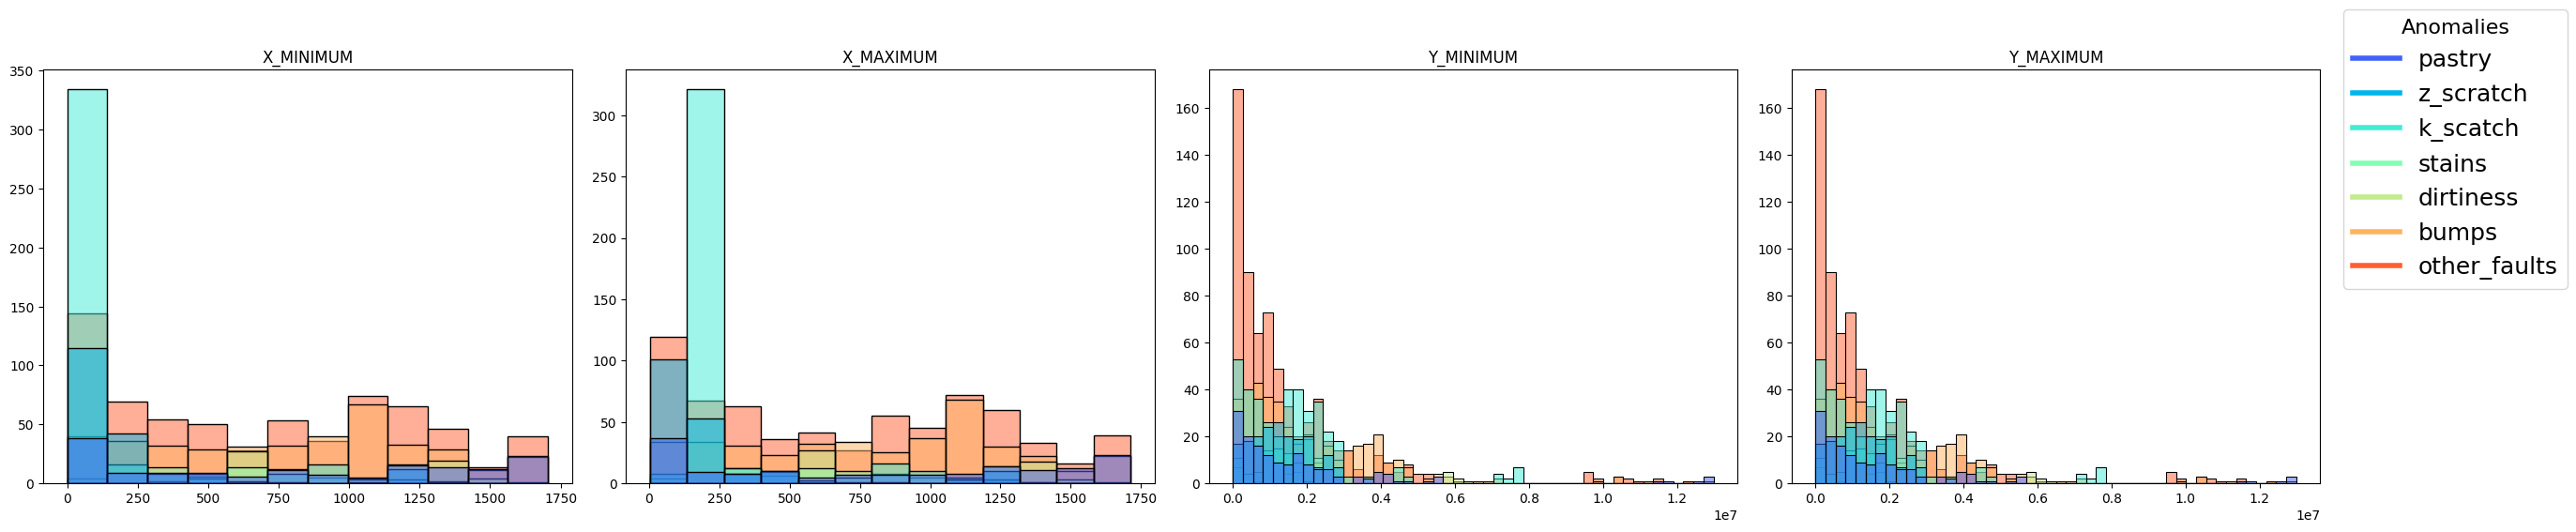

In [13]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

palette_hist = sns.color_palette('rainbow', n_colors = len(df['anomaly'].unique()))
hue_order = df['anomaly'].unique()

colors = sns.color_palette('rainbow', len(target_cols))
handles = [plt.Line2D([0], [0], color = colors[i], lw = 4, label = str(target_cols[i])) for i in range(len(target_cols))]

for index, col in enumerate(feat_col[:4]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

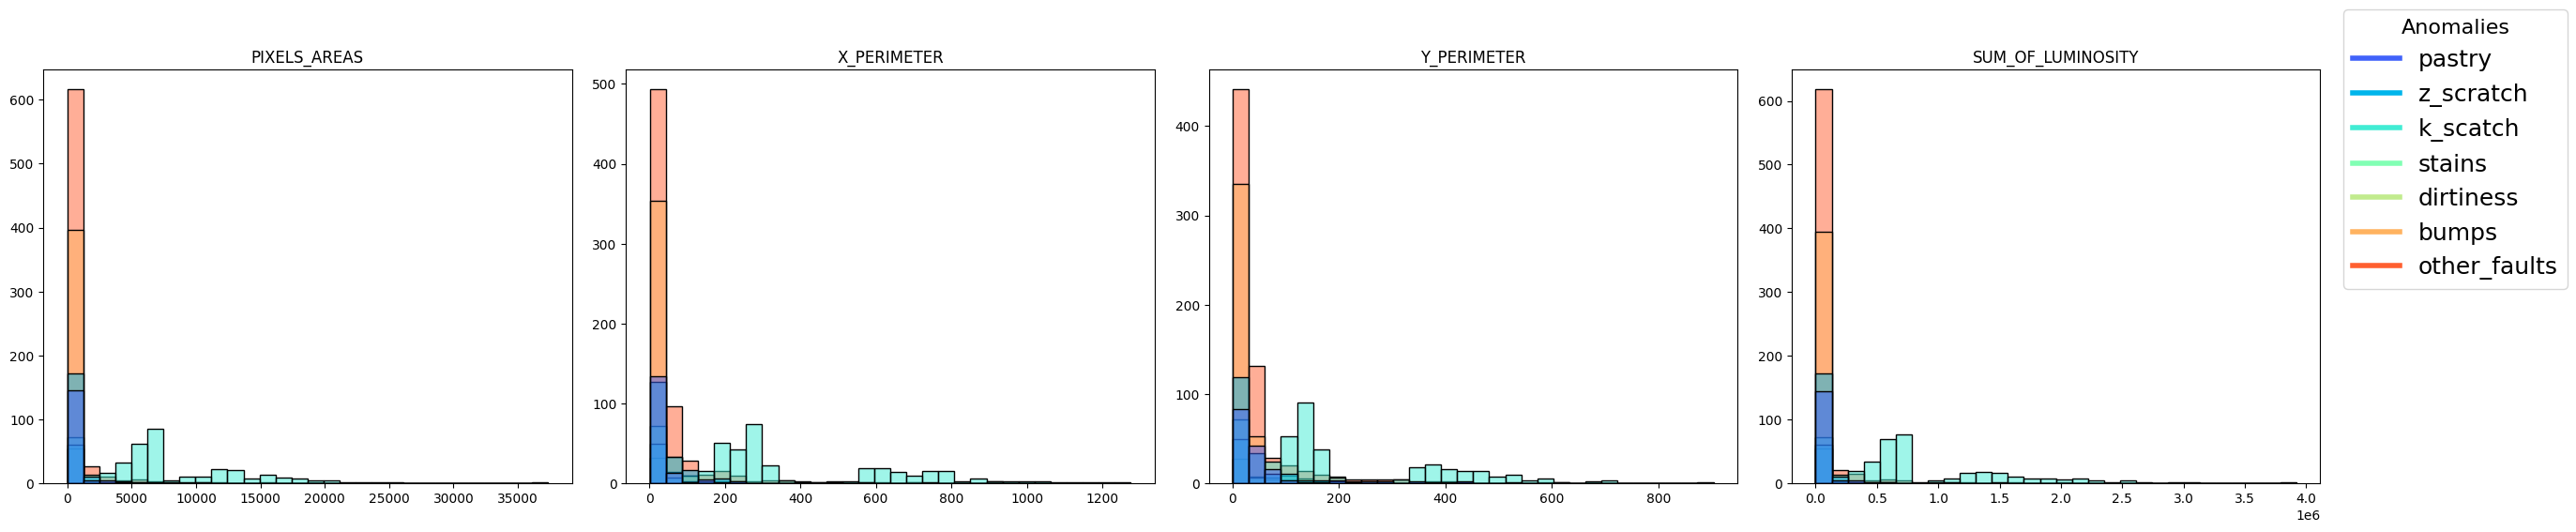

In [14]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[4:8]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False, bins = 30)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('') 

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

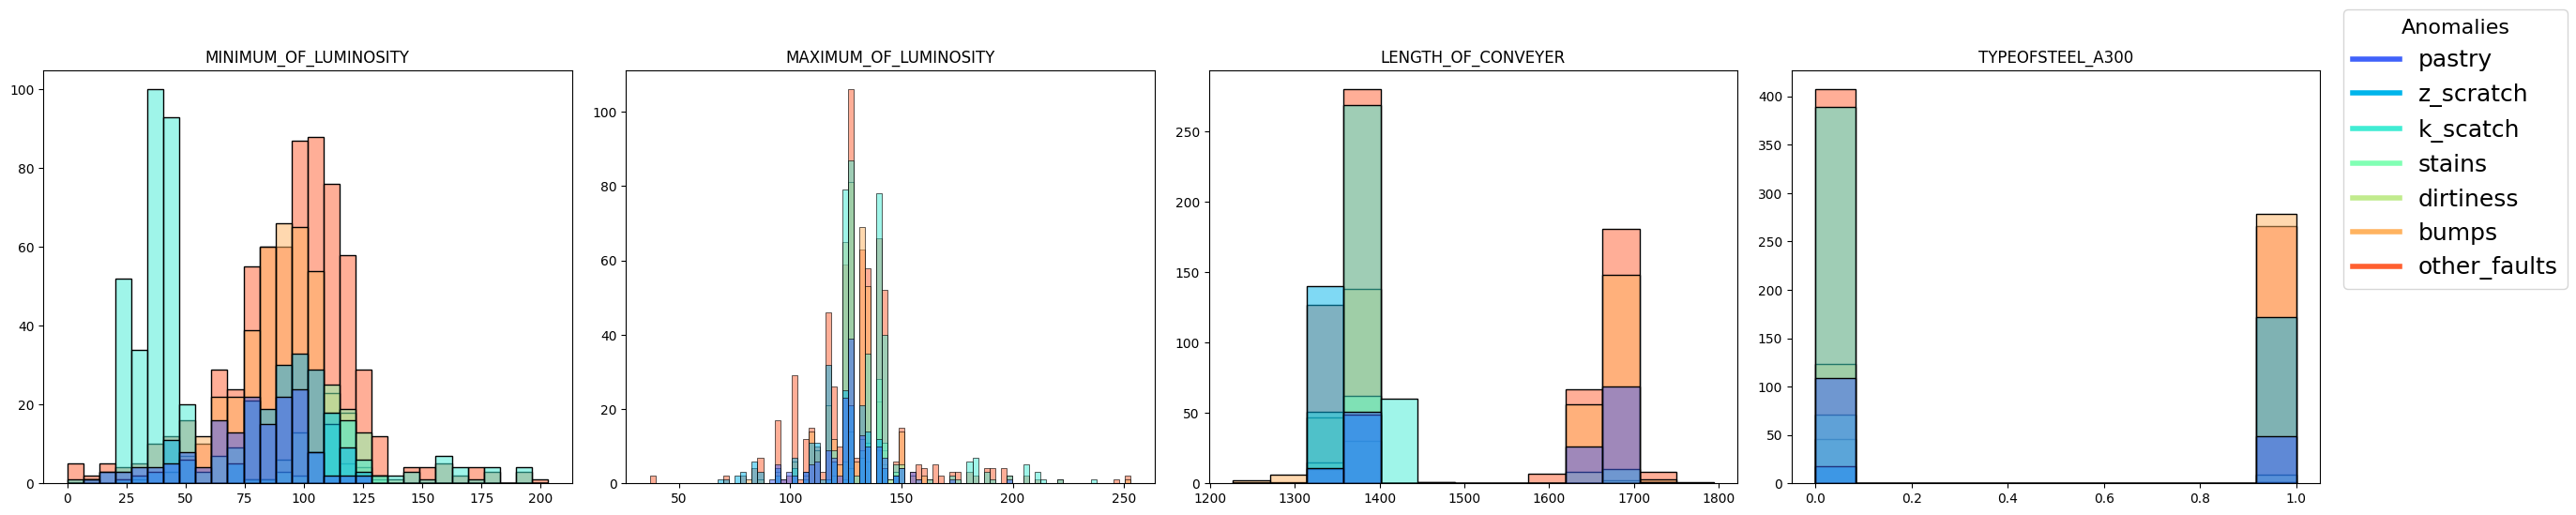

In [15]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[8:12]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

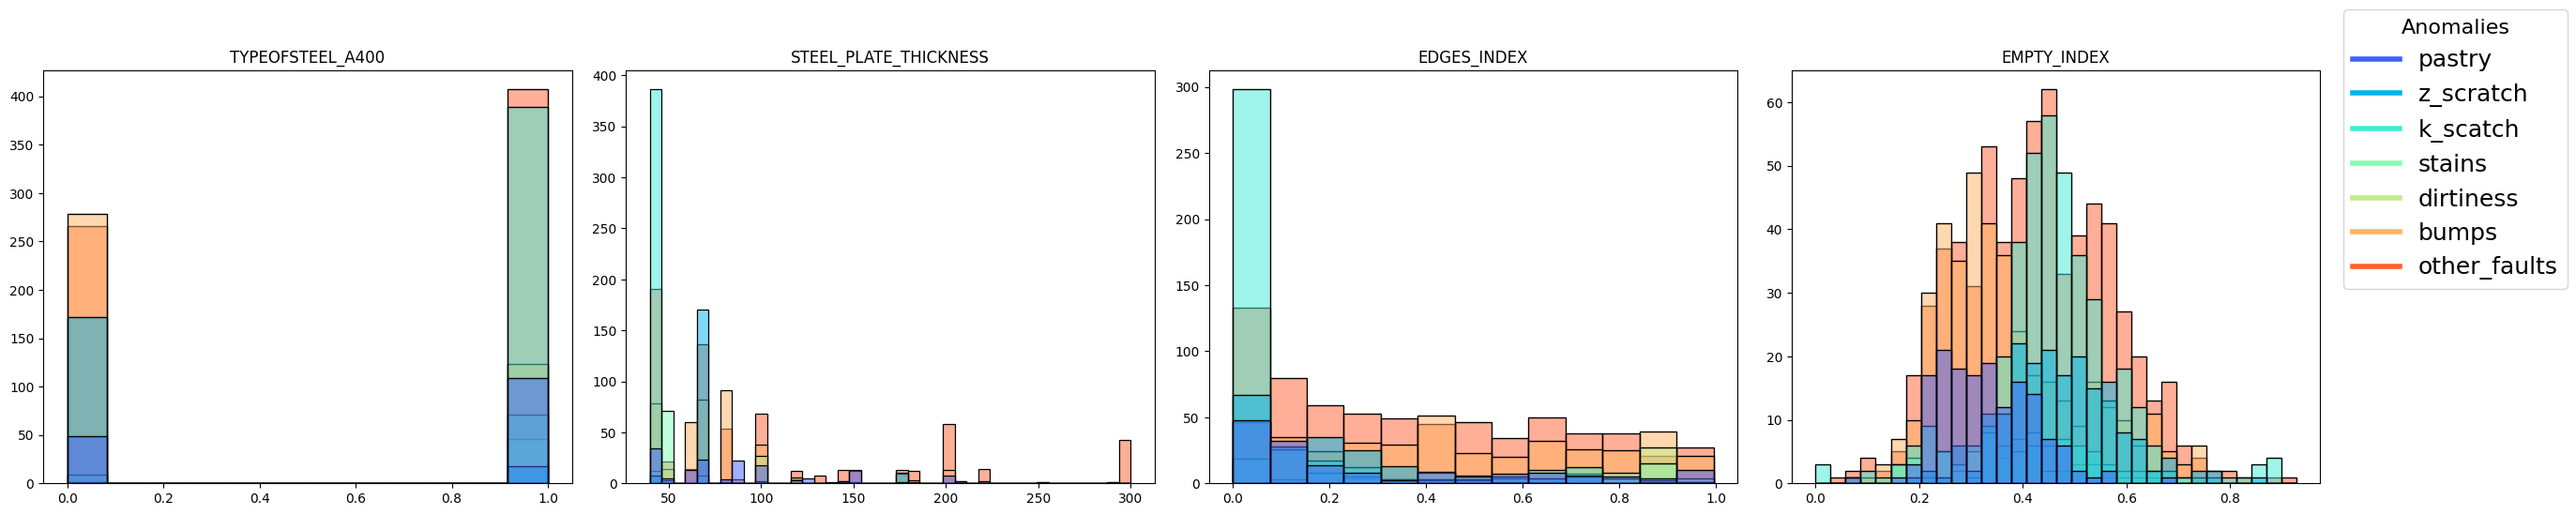

In [16]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[12:16]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

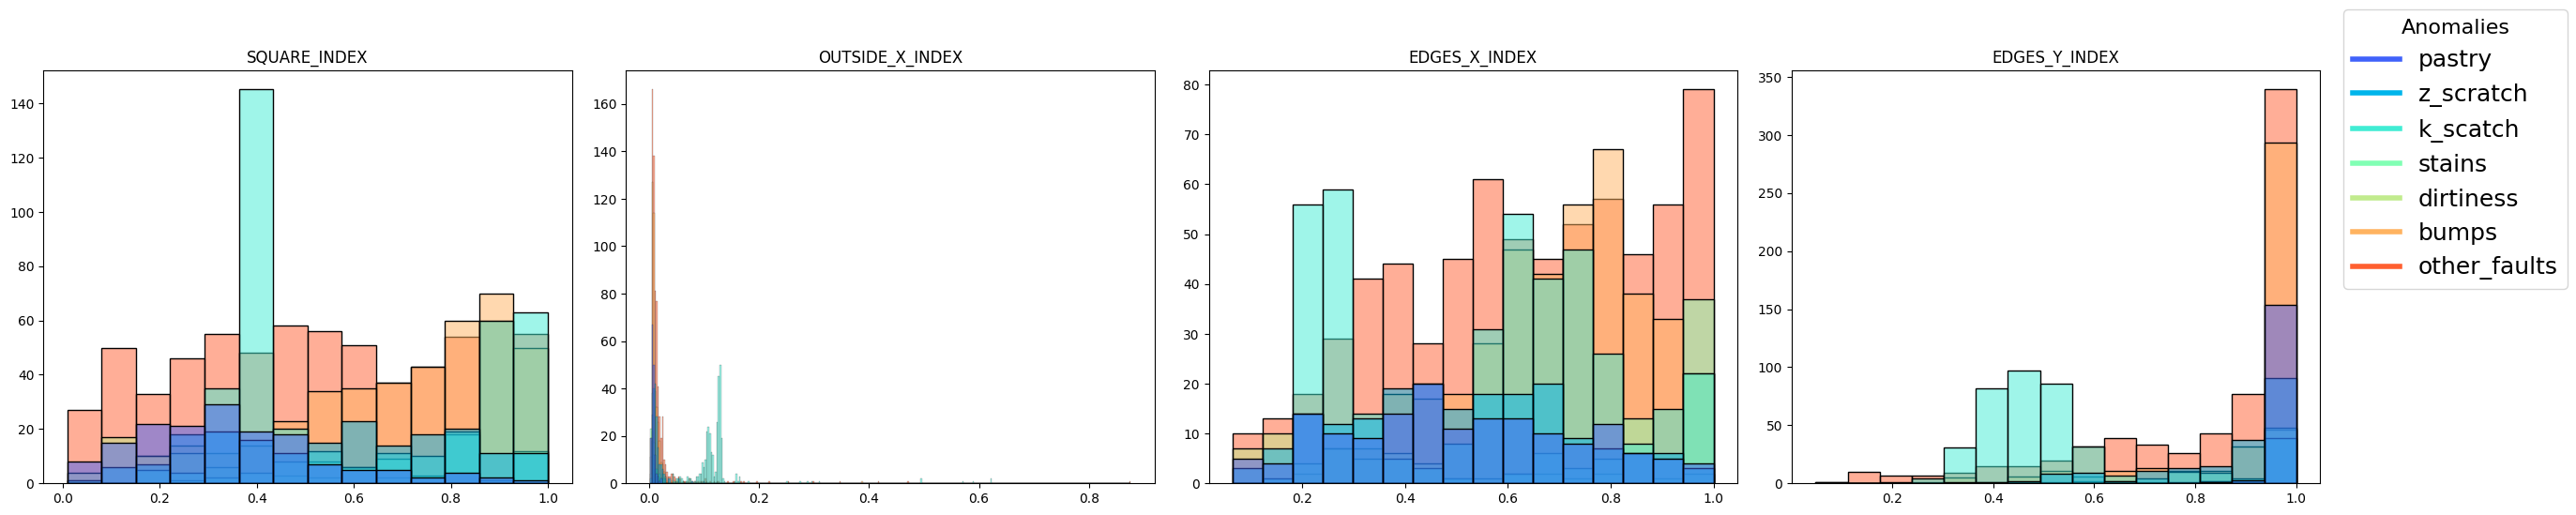

In [17]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[16:20]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

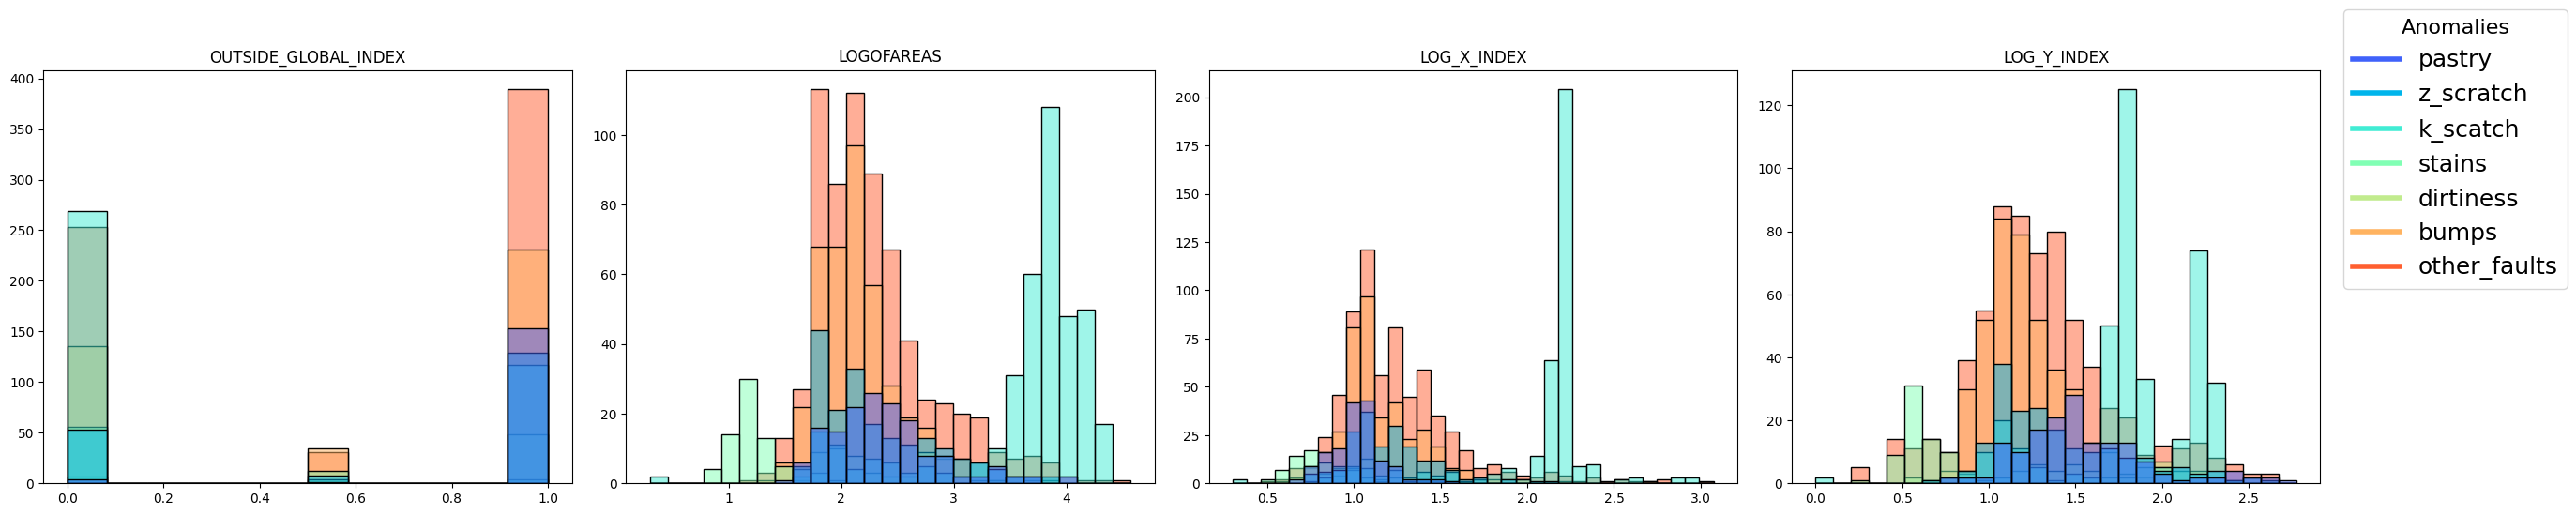

In [18]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[20:24]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

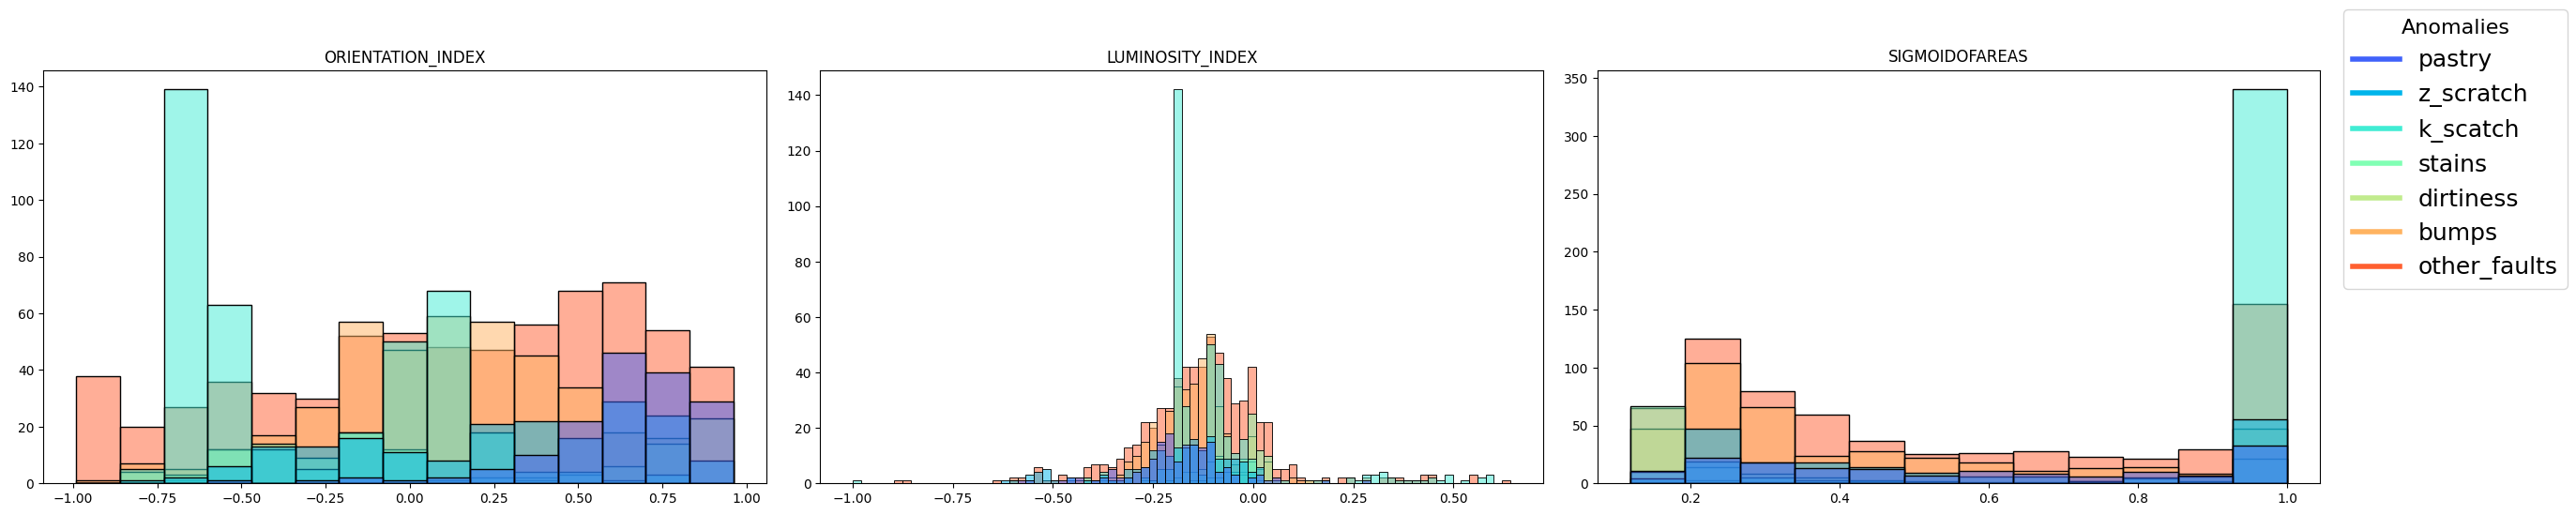

In [19]:
fig, ax = plt.subplots(1, 3, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[24:27]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

## Boxplots of the features

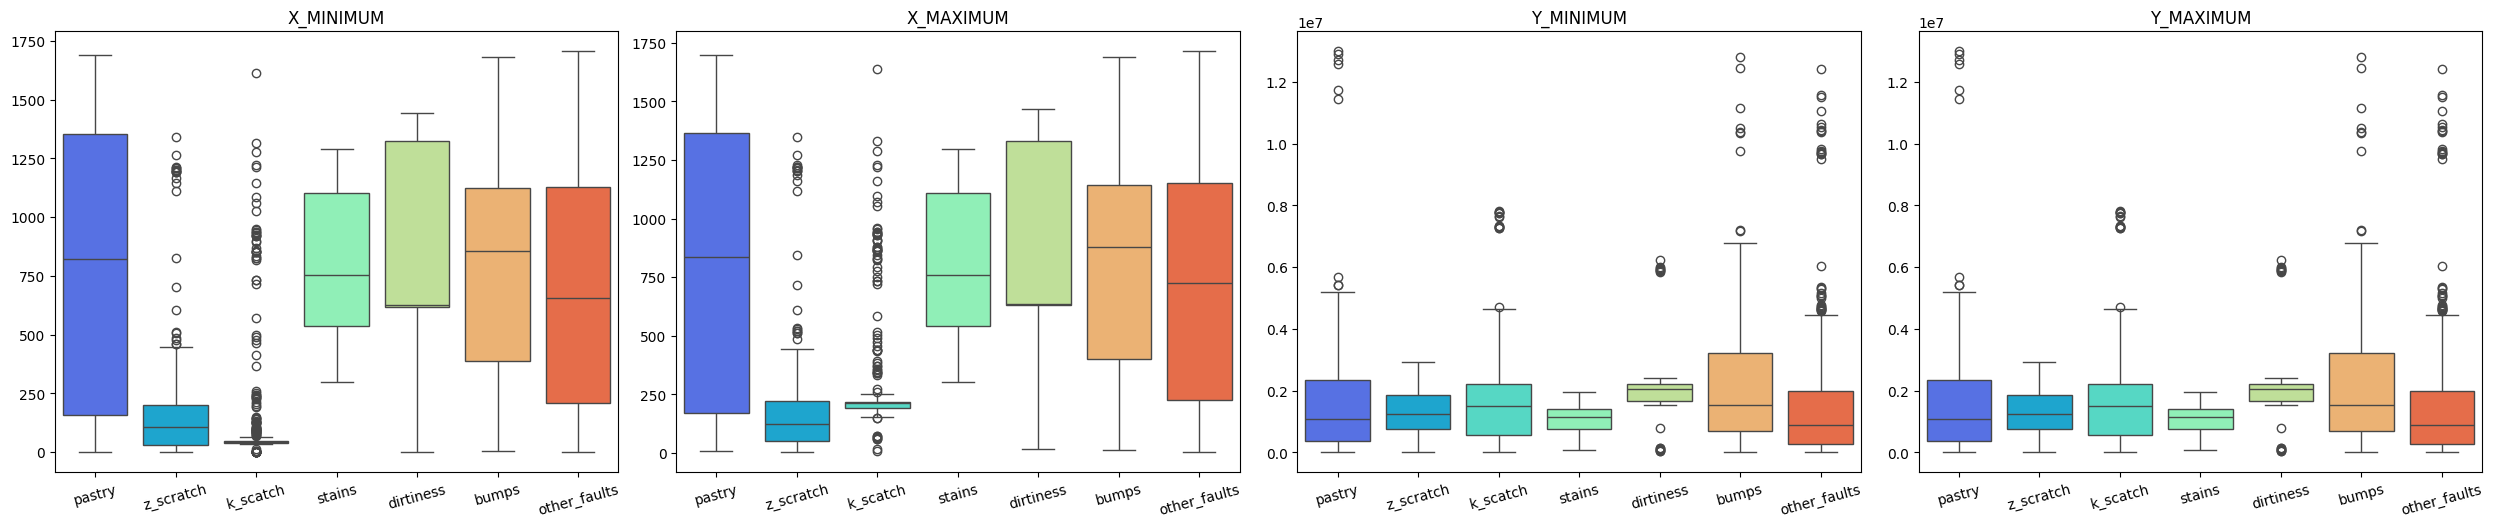

In [20]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[:4]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

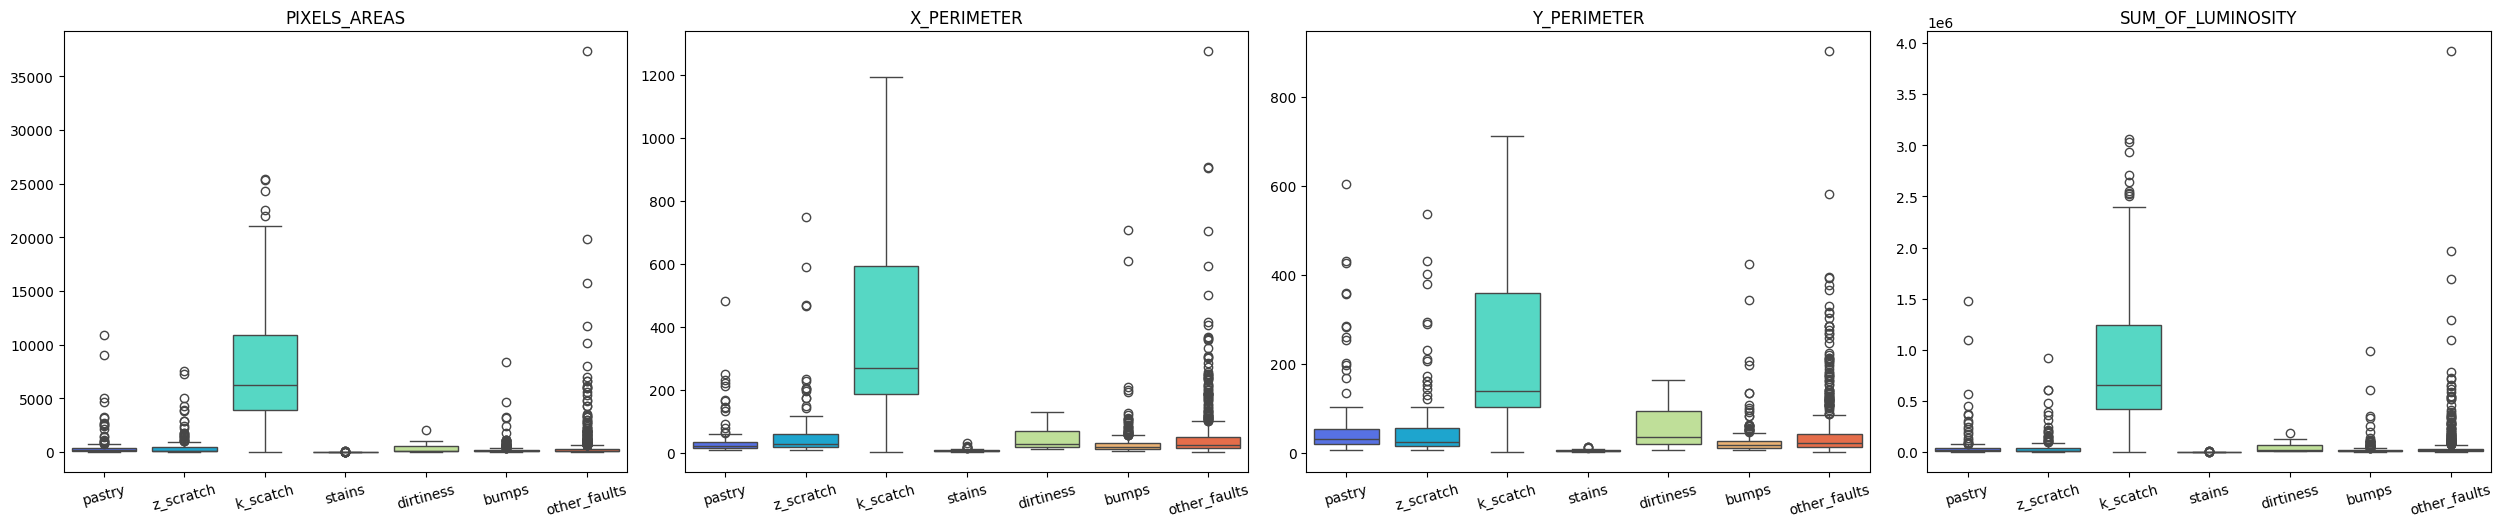

In [21]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[4:8]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

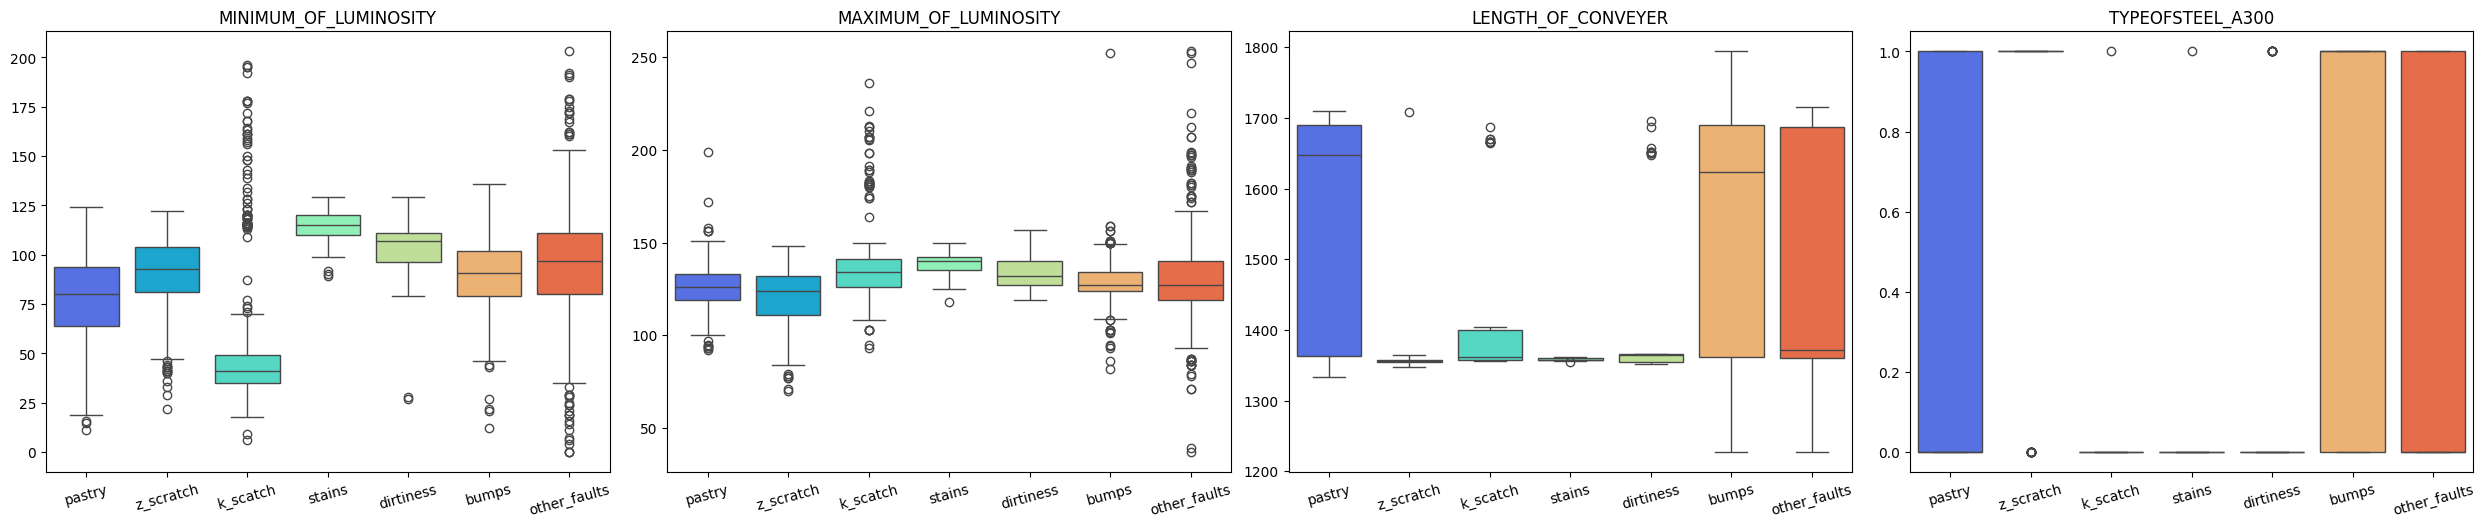

In [22]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[8:12]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

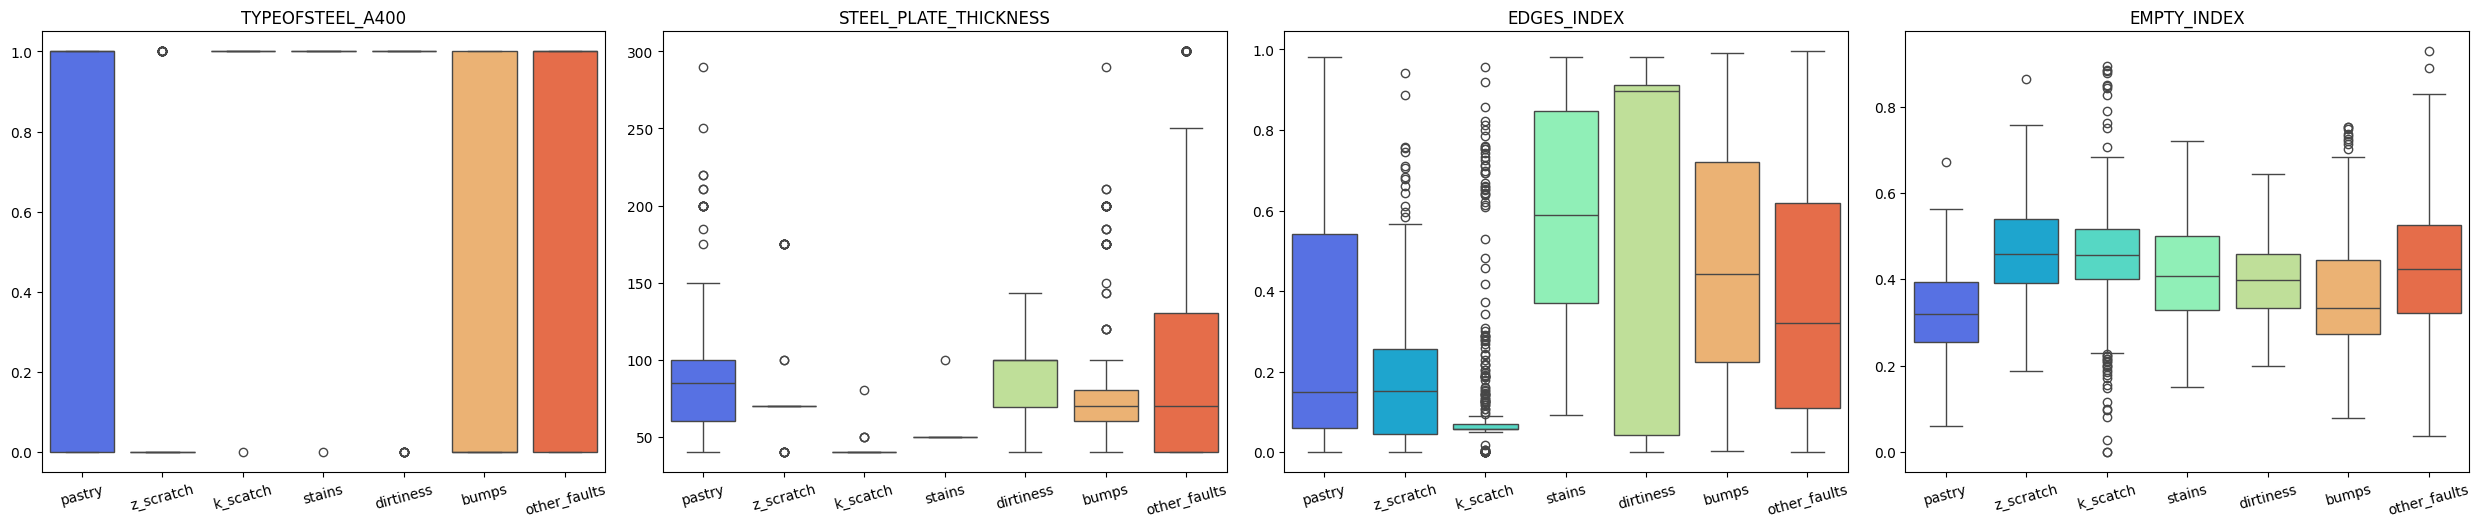

In [23]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[12:16]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

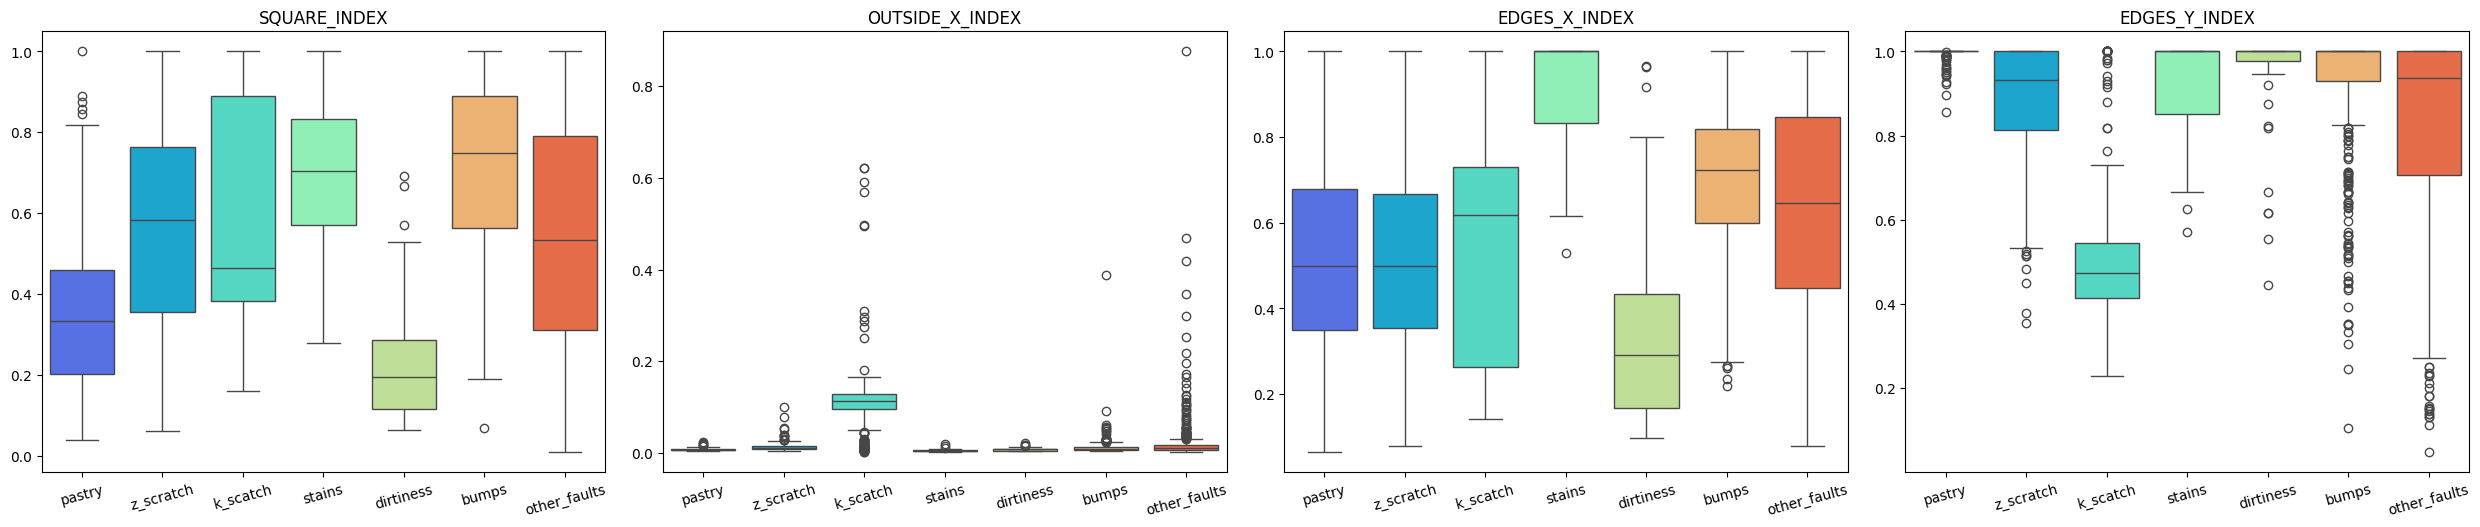

In [24]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[16:20]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

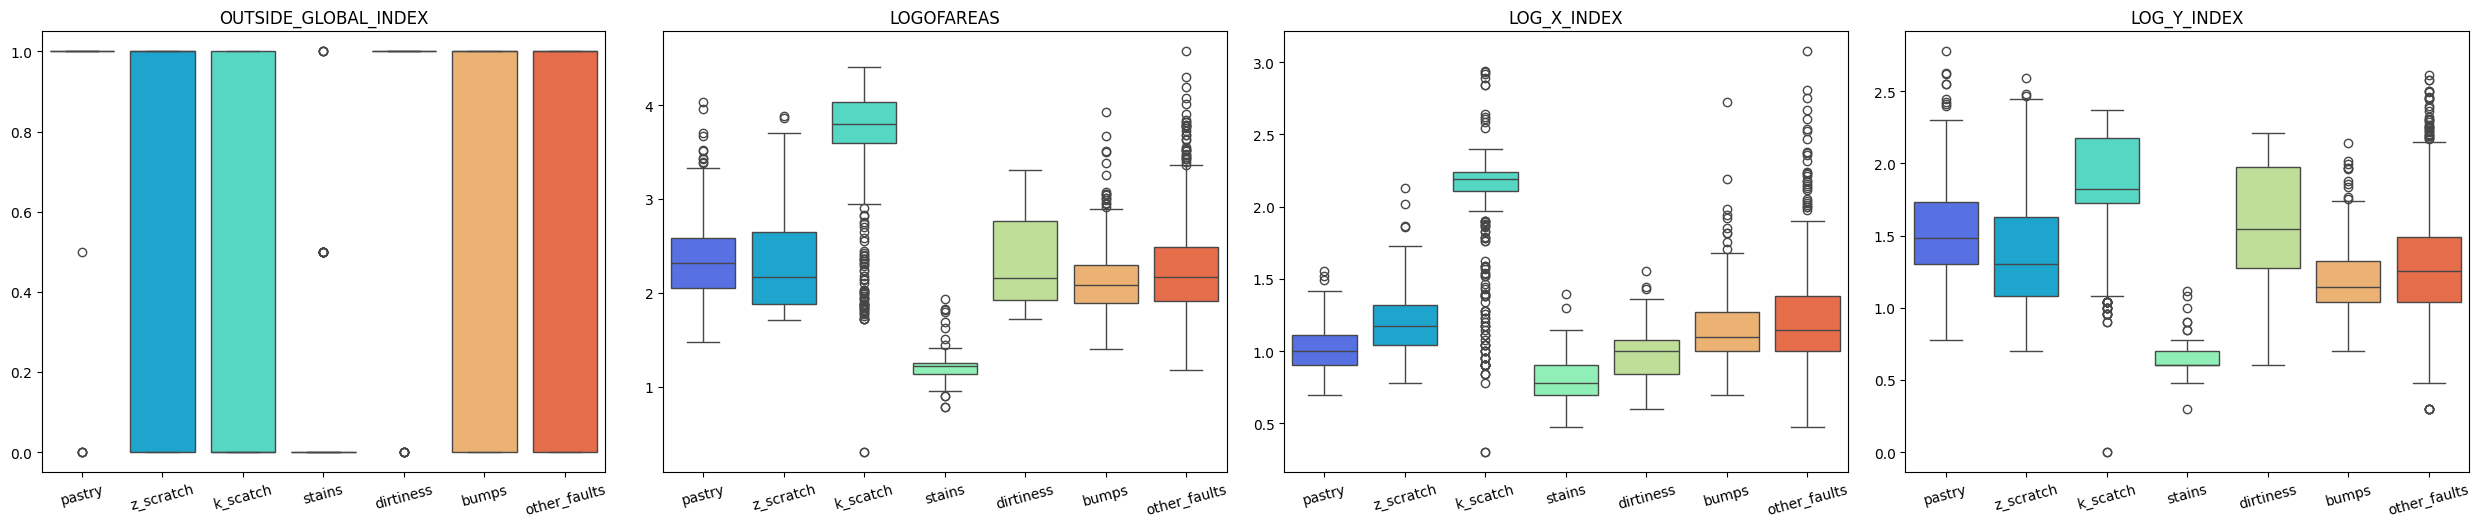

In [25]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[20:24]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

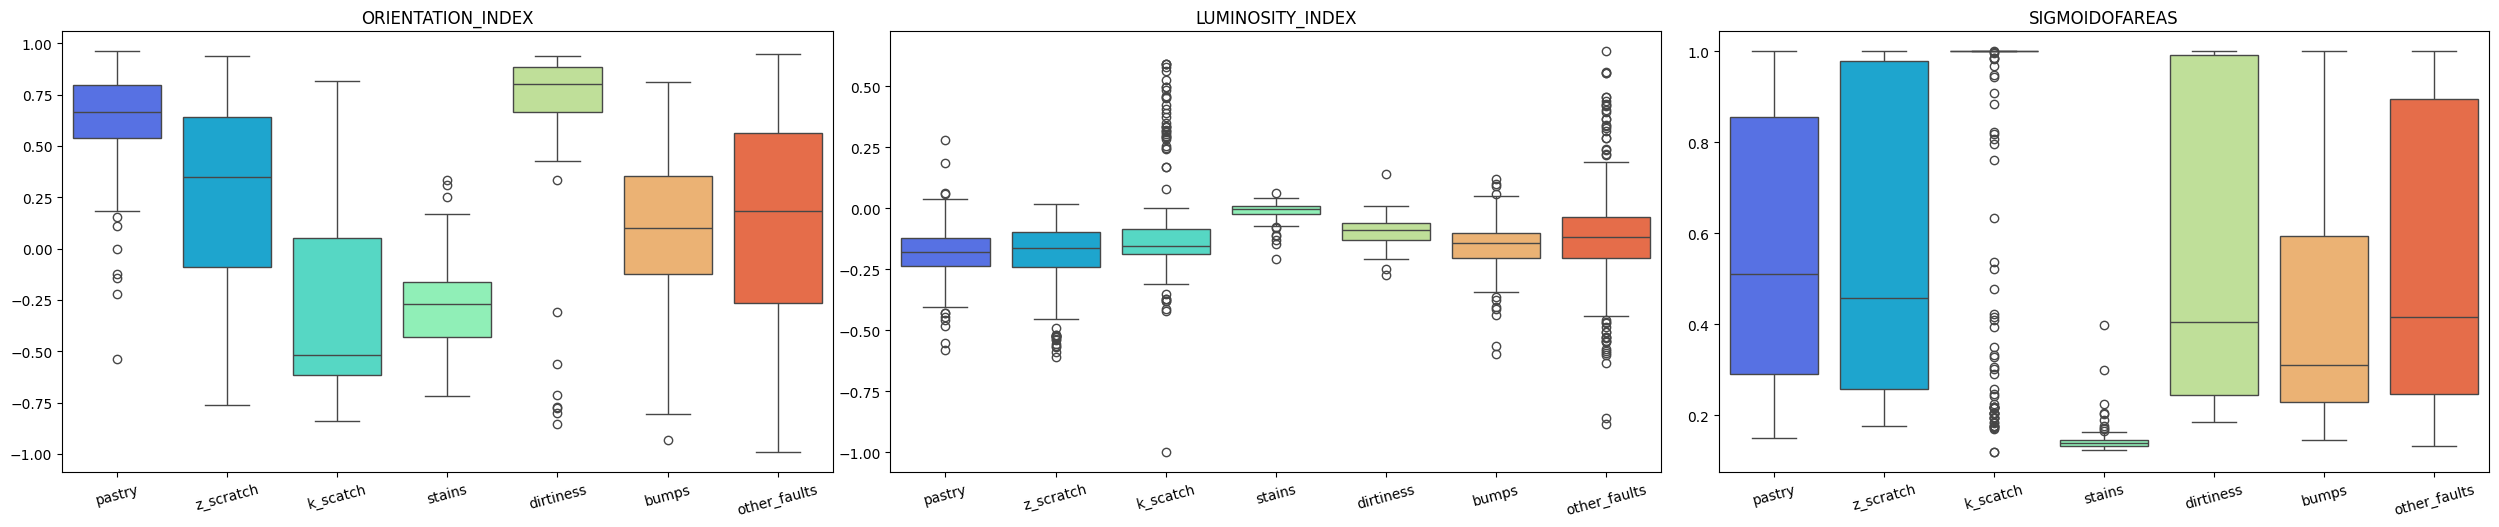

In [26]:
fig, ax = plt.subplots(1, 3, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[24:27]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

Check for binary features

In [27]:
for col in feat_col:
    if len(df[col].unique()) <= 2:
        print(f'Feature {col} has binary data (e.g. 0-1)')

# also check 'outside_global_index' feature
unique_ogi_feature = df['outside_global_index'].unique()
print(f'Feature outside_global_index has {len(unique_ogi_feature)} unique values, which are {str(unique_ogi_feature).strip("[").strip("]")}')

Feature typeofsteel_a300 has binary data (e.g. 0-1)
Feature typeofsteel_a400 has binary data (e.g. 0-1)
Feature outside_global_index has 3 unique values, which are 1.  0.5 0. 


## Correlation between features

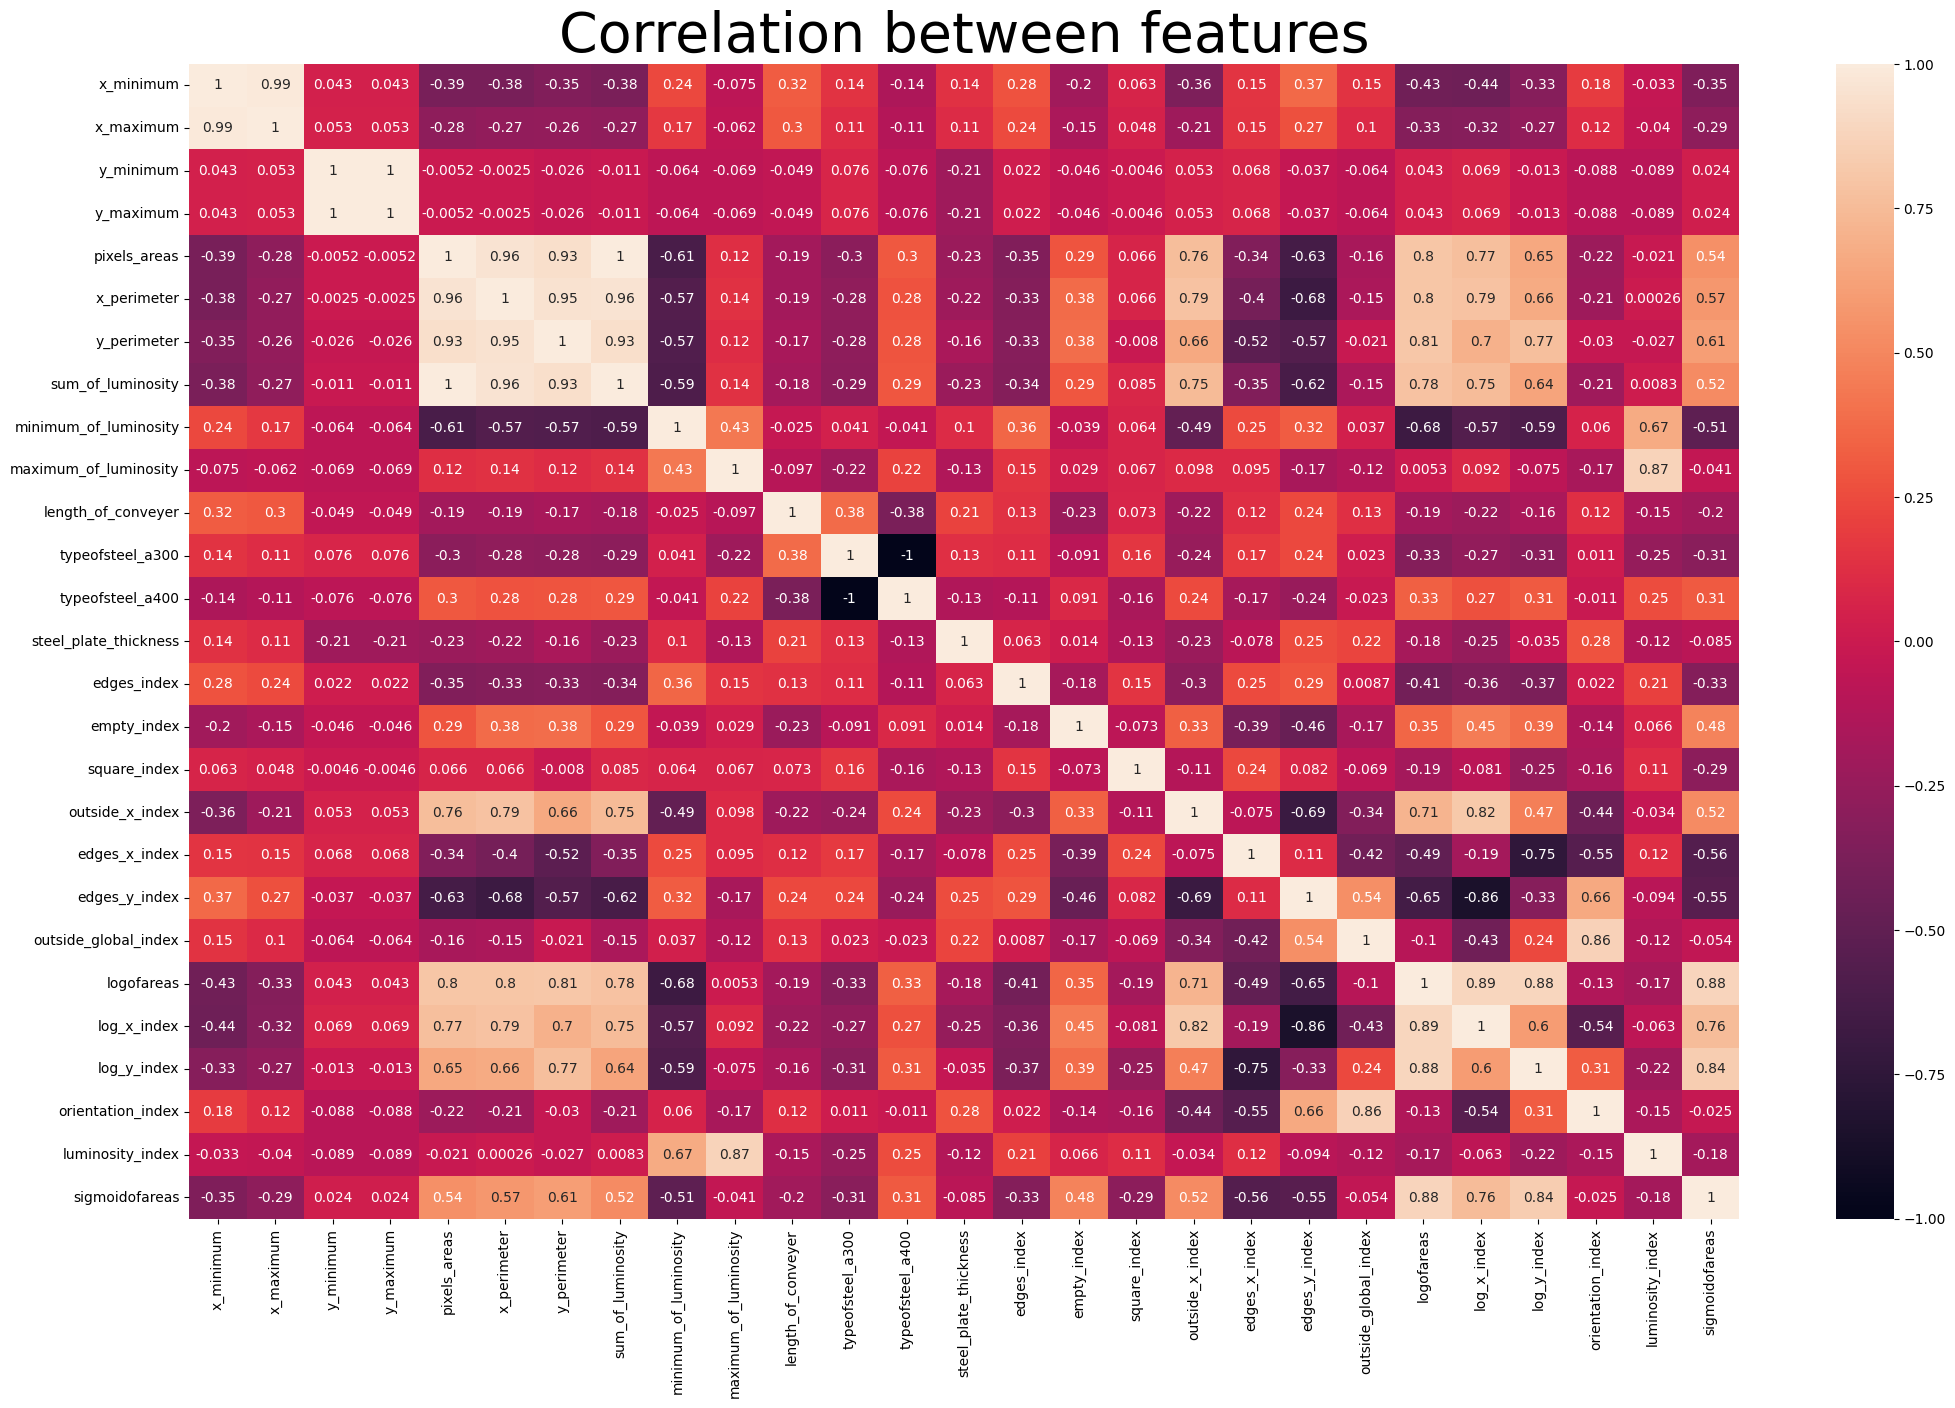

In [28]:
corr = df[feat_col].corr()

plt.figure(figsize = (25, 15))
plt.title('Correlation between features', fontsize = 40)
sns.heatmap(corr, annot = True)#, cbar = False)
plt.show()

We clearly see that some of our features have high correlations between each others, particularly a lot of features have correlation higher than 0.33 or lower than -0.33. This means we could use some feature engineering

Plot some relevant features (Pearson corr > 95%) so that we can better see their correlation

In [29]:
corr[corr > 0.95].replace({1.0 : np.nan}).dropna(how = 'all').dropna(axis = 1, how = 'all')

,x_minimum,x_maximum,y_minimum,y_maximum,pixels_areas,x_perimeter,y_perimeter,sum_of_luminosity
x_minimum,NaN,0.988314,NaN,NaN,NaN,NaN,NaN,NaN
x_maximum,0.988314,NaN,NaN,NaN,NaN,NaN,NaN,NaN
y_minimum,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
y_maximum,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
pixels_areas,NaN,NaN,NaN,NaN,NaN,0.959504,NaN,0.996767
x_perimeter,NaN,NaN,NaN,NaN,0.959504,NaN,0.952089,0.960622
y_perimeter,NaN,NaN,NaN,NaN,NaN,0.952089,NaN,NaN
sum_of_luminosity,NaN,NaN,NaN,NaN,0.996767,0.960622,NaN,NaN


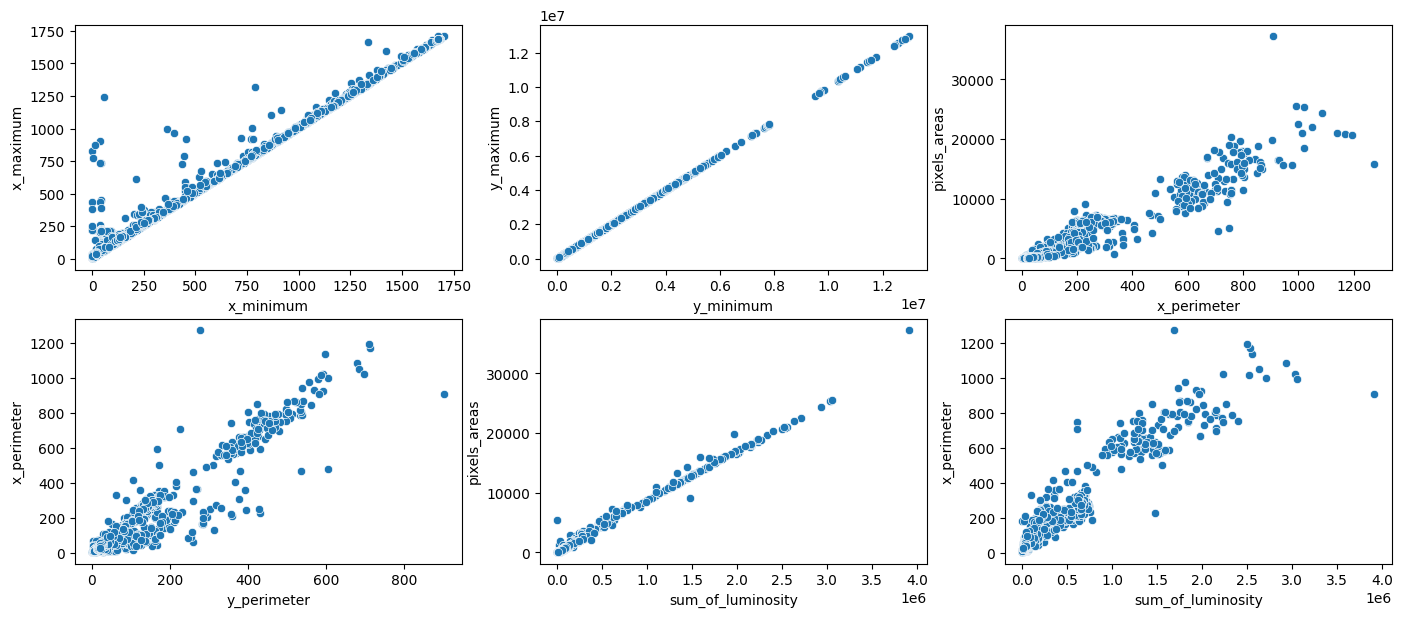

In [30]:
fig, ax = plt.subplots(2, 3, figsize = (17, 7))
plt.tight_layout

sns.scatterplot(data = df, x = 'x_minimum', y = 'x_maximum', ax = ax[0][0])
sns.scatterplot(data = df, x = 'y_minimum', y = 'y_maximum', ax = ax[0][1])
sns.scatterplot(data = df, x = 'x_perimeter', y = 'pixels_areas', ax = ax[0][2])
sns.scatterplot(data = df, x = 'y_perimeter', y = 'x_perimeter', ax = ax[1][0])
sns.scatterplot(data = df, x = 'sum_of_luminosity', y = 'pixels_areas', ax = ax[1][1])
sns.scatterplot(data = df, x = 'sum_of_luminosity', y = 'x_perimeter', ax = ax[1][2])

plt.show()

We clearly see a strong linearity between the features. Unfortunately, except x_minimum/x_maximum and y_minimum/y_maximum, all the other features are on very different range of data. This means that we can't use simple mean for aggregating some of these features. First, we will need to normalize the data via z-score, and then aggregate some features.

## Normalize the data

Since normalizing binary data doesn't make sense->remove the binary features, normalize the remaining features and then re-add the binary ones.

In [31]:
df_nonbin = df.drop(['typeofsteel_a300', 'typeofsteel_a400', 'outside_global_index', 'anomaly'], axis = 1).drop(target_cols, axis = 1)

In [32]:
sc = StandardScaler()
# normalize the non binary dataframe
nonbin_norm = sc.fit_transform(df_nonbin)
# transform the standardized array into a dataframe
df_nonbin_norm = pd.DataFrame(nonbin_norm, columns = df_nonbin.columns)
# copy the non binary dataframe, so that we can add binary features to the new one
df_norm = df_nonbin_norm.copy()
df_norm[['typeofsteel_a300', 'typeofsteel_a400', 'outside_global_index', 'anomaly']] = df[['typeofsteel_a300', 'typeofsteel_a400', 'outside_global_index', 'anomaly']]
del nonbin_norm
df_norm.head()

,x_minimum,x_maximum,y_minimum,y_maximum,pixels_areas,x_perimeter,y_perimeter,sum_of_luminosity,minimum_of_luminosity,maximum_of_luminosity,...,logofareas,log_x_index,log_y_index,orientation_index,luminosity_index,sigmoidofareas,typeofsteel_a300,typeofsteel_a400,outside_global_index,anomaly
0,-1.017061,-1.142050,-0.777201,-0.777202,-0.400113,-0.474372,-0.255137,-0.398460,-0.267865,-1.187274,...,-0.082004,-0.898011,0.537478,1.469459,-1.077382,-0.008861,1.0,0.0,1.0,0.0
1,0.141352,0.065935,0.501065,0.501057,-0.441179,-0.511463,-0.375599,-0.427454,-0.018464,-0.384353,...,-0.581776,-1.157553,0.134760,1.419304,-0.298967,-0.845237,1.0,0.0,1.0,0.0
2,0.494831,0.435767,-0.053821,-0.053836,-0.450735,-0.522060,-0.470247,-0.435198,0.449163,-0.277297,...,-0.813291,-1.157553,-0.325776,1.166727,0.056266,-1.091022,1.0,0.0,1.0,0.0
3,0.540937,0.486016,-0.721683,-0.721683,-0.423616,-0.495567,-0.246533,-0.410272,0.449163,-0.223769,...,-0.312120,-1.018535,0.559048,1.521813,-0.172482,-0.188632,0.0,1.0,1.0,0.0
4,1.378530,1.382457,-0.649115,-0.648996,0.153115,-0.246530,1.603407,0.105111,-1.483695,-0.223769,...,1.132527,-0.217676,2.241749,1.700455,-0.457745,1.222421,0.0,1.0,1.0,0.0


In [33]:
# check for standardization
norm_dict = {}
for col in feat_col:
    norm_dict[col] = [round(df_norm[col].mean(), 5), round(df_norm[col].var(), 5)]
    if col == feat_col[-1]:
        display(pd.DataFrame(norm_dict, index = ['Mean', 'Variance']).T)

,Mean,Variance
x_minimum,0.00000,1.00052
x_maximum,0.00000,1.00052
y_minimum,0.00000,1.00052
y_maximum,0.00000,1.00052
pixels_areas,-0.00000,1.00052
x_perimeter,0.00000,1.00052
y_perimeter,0.00000,1.00052
sum_of_luminosity,0.00000,1.00052
minimum_of_luminosity,-0.00000,1.00052
maximum_of_luminosity,-0.00000,1.00052


Data has been correcly standardized since the only features that don't have mean = 0 and variance = 1 are the binary features

## Aggregate features

Aggregate features that have high correlation

In [34]:
df_norm['aggregate1'] = df_norm[['y_minimum', 'y_maximum']].mean(axis = 1)
df_norm.drop(['y_minimum', 'y_maximum'], axis = 1, inplace = True)
df_norm['aggregate2'] = df_norm[['x_minimum', 'x_maximum']].mean(axis = 1)
df_norm.drop(['x_minimum', 'x_maximum'], axis = 1, inplace = True)
df_norm['aggregate3'] = df_norm[['x_perimeter', 'pixels_areas']].mean(axis = 1)
df_norm['aggregate4'] = df_norm[['y_perimeter', 'x_perimeter']].mean(axis = 1)
df_norm.drop(['y_perimeter'], axis = 1, inplace = True)
df_norm['aggregate5'] = df_norm[['sum_of_luminosity', 'pixels_areas']].mean(axis = 1)
df_norm.drop(['pixels_areas'], axis = 1, inplace = True)
df_norm['aggregate6'] = df_norm[['sum_of_luminosity', 'x_perimeter']].mean(axis = 1)
df_norm.drop(['sum_of_luminosity', 'x_perimeter'], axis = 1, inplace = True)
df_norm.dropna(inplace = True)

## Visualizing the classes

In [35]:
df_norm.dropna(inplace = True)

pca = PCA(n_components = 3)  
X = df_norm.drop('anomaly', axis = 1)
df_PCA = pca.fit_transform(X)
df_PCA = pd.DataFrame(df_PCA, columns = ['PC1', 'PC2', 'PC3'])
df_PCA['anomaly'] = df_norm['anomaly']

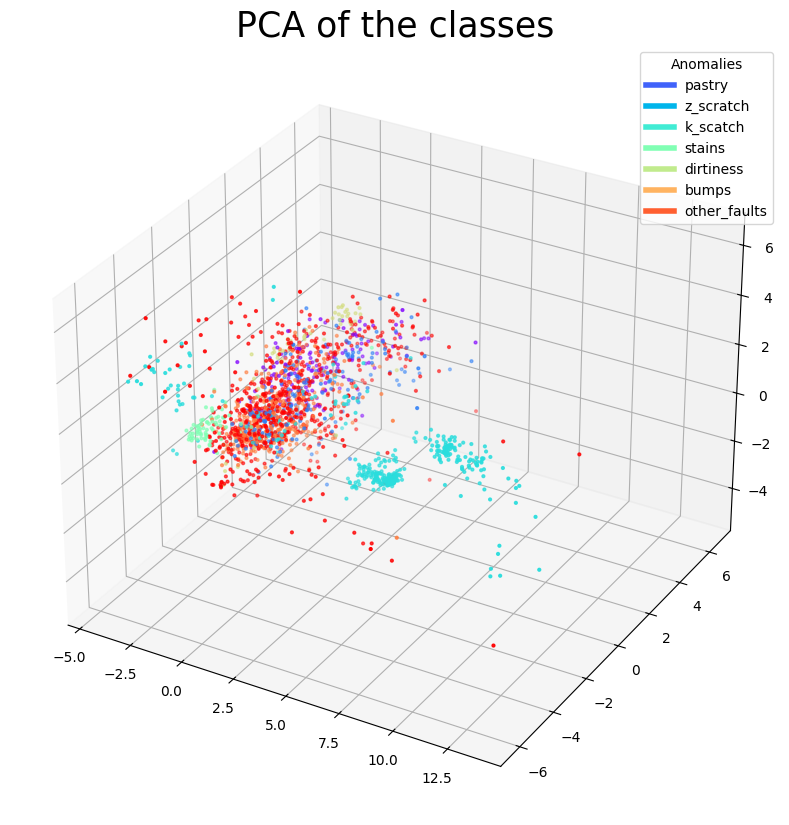

In [36]:
# %matplotlib qtagg 
# uncomment the previous line of code if you want to display interactive plot

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(projection='3d')
ax.set_title('PCA of the classes', fontsize = 25)
cmap = ListedColormap(sns.color_palette('rainbow', 256).as_hex())

ax.scatter(xs = df_PCA['PC1'], ys = df_PCA['PC2'], zs = df_PCA['PC3'], c = df_PCA['anomaly'], s = 4, cmap = cmap)

plt.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "best")

plt.show()

Seems like PCA doesn't do a great job with this datasets when it comes to visualizing clusters of the classes, perhaps because of the non-linearity of the correlations between the features. 

Try with different methods t-SNE/UMAP

In [ ]:
ump = umap.UMAP(n_neighbors = 10, n_components = 3, random_state = 2)

df_umap = ump.fit_transform(df_norm)

df_umap = pd.merge(pd.DataFrame(df_umap), df_norm['anomaly'], left_index = True, right_index = True)

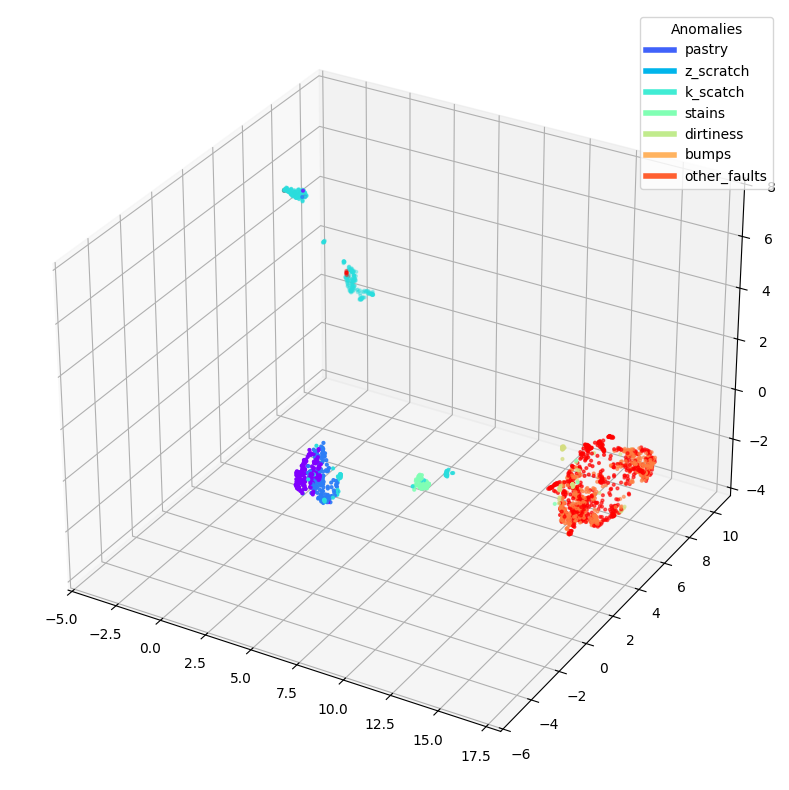

In [38]:
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(projection = '3d')
cmap = ListedColormap(sns.color_palette('rainbow', 256).as_hex())

ax.scatter(df_umap[0], df_umap[1], df_umap[2], c = df_umap['anomaly'], s = 4, cmap = cmap)

plt.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "best")

plt.show()

UMAP does a better then PCA when it comes to dimensionality reduction while preserving the clusterization of the different classes. This implies non-linearity in the correlation between the features, and that it might be better to use this dimensionality reducted dataframe insteand of the original one or the PCA one (maybe with a number of components greater than 3).

## Outlier detection

From the boxplots we can clearly see that the dataset seems to present a lot of outliers. Check if these samples need to be removed or not

In [39]:
df_iqr = df.drop(target_cols, axis = 1)
Q1 = df_iqr.quantile(0.25)
Q3 = df_iqr.quantile(0.75)
IQR = Q3 - Q1

df_iqr = df_iqr[~((df_iqr < (Q1 - 1.5 * IQR)) | (df_iqr > (Q3 + 1.5 * IQR))).any(axis = 1)]
df_iqr[target_cols] = df[target_cols]

In [40]:
anomaly_count_iqr = pd.DataFrame(df_iqr['anomaly'].value_counts()).sort_index()
anomaly_count_iqr
anomaly_count_iqr.index = target_cols
display(anomaly_count_iqr, anomaly_count_iqr - anomaly_count)
lost_samples = round((len(df) - len(df_iqr)) / len(df), 2) * 100
print(f"The dataset lost {lost_samples}% of it's samples")
del df_iqr, anomaly_count_iqr

,count
pastry,103
z_scratch,150
k_scatch,23
stains,72
dirtiness,46
bumps,334
other_faults,389


,count
pastry,-55
z_scratch,-40
k_scatch,-368
stains,0
dirtiness,-9
bumps,-68
other_faults,-284


The dataset lost 42.0% of it's samples


We can see that some anomalies are greatly affected by the IQR outlier deletion. Specifically, k_scratch which was one of the most represented in the dataset, lost 368 samples remaining with only 24. Since we loose a lot of representation, and also because such extreme values of the features specifically for k_scratch might not be casual and our models could theoretically learn this relation, choose to use the datasets without IQR applied. Also, 42% of the dataset would be lost if we applied this outlier detection.

## Naive Bayes temporary

In [41]:
df_norm.dropna(inplace = True)

In [42]:
gnb = GaussianNB()

In [43]:
X = df_umap.drop('anomaly', axis = 1)
y = df_umap['anomaly']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

In [44]:
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

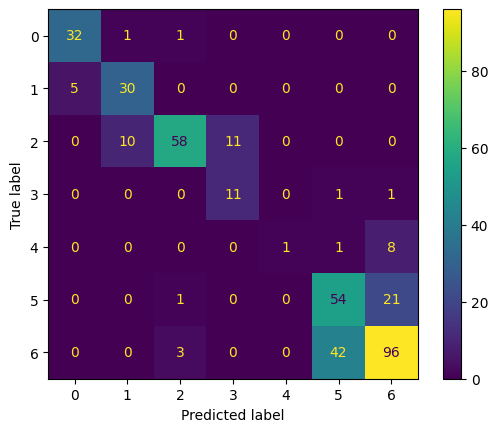

In [45]:
import matplotlib
matplotlib.use('inline')
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

In [46]:
print(f'Accuracy score: {round(accuracy_score(y_test, y_pred), 2)}%')

Accuracy score: 0.73%


From the confusion matrix we clearly see that the Gaussian model particularly fails to guess feature 6, "Other faults". Try balancing the classes in the dataset and apply weights to the fitting.

In [47]:
ros = RandomOverSampler()
X_res, y_res = ros.fit_resample(X, y)

In [48]:
df_norm_res = pd.merge(pd.DataFrame(X_res), pd.DataFrame(y_res), left_index = True, right_index = True)
anomaly_count_res = pd.DataFrame(df_norm_res['anomaly'].value_counts()).sort_index()
anomaly_count_res.index = target_cols
anomaly_count_res

,count
pastry,671
z_scratch,671
k_scatch,671
stains,671
dirtiness,671
bumps,671
other_faults,671


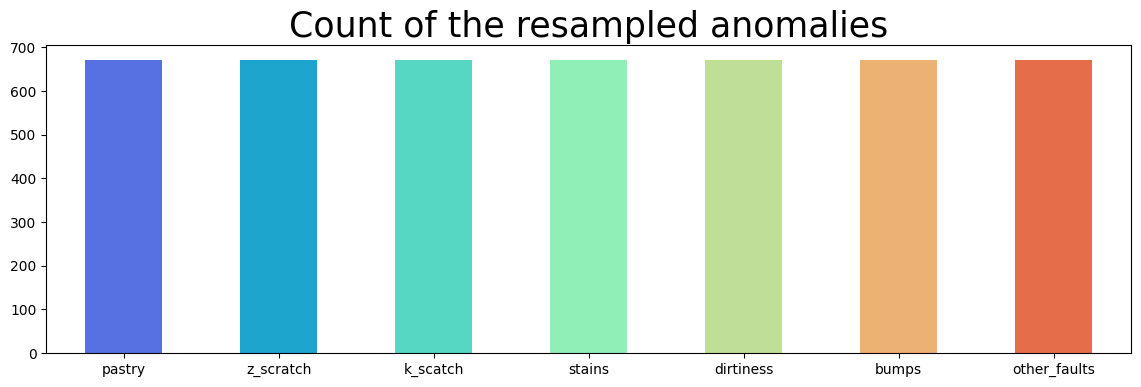

In [49]:
plt.figure(figsize = (14, 4))
sns.barplot(anomaly_count_res, x = anomaly_count_res.index, y = 'count', hue = anomaly_count_res.index, palette = 'rainbow', width = 0.5)
plt.title('Count of the resampled anomalies', fontsize = 25)
plt.xlabel('')
plt.ylabel('')
plt.show()

In [50]:
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res, test_size = 0.2, random_state = 2)

In [51]:
gnb.fit(X_train_res, y_train_res)
y_pred = gnb.predict(X_test_res)

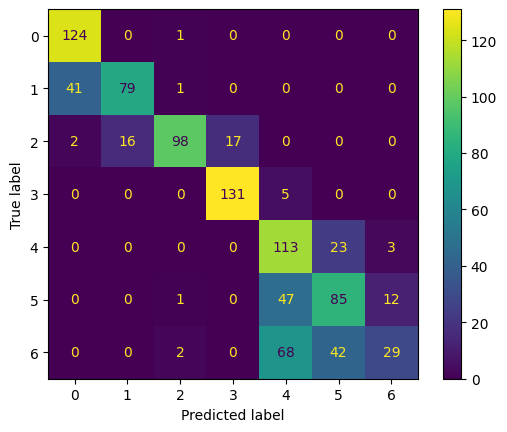

In [52]:
cm = confusion_matrix(y_test_res, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

In [53]:
print(f'Accuracy score: {round(accuracy_score(y_test_res, y_pred), 2)}%')

Accuracy score: 0.7%


NEXT STEPS

hyp tuning, SMOTE, feat eng polynomial features, Apply transformations like log, sqrt, or Box-Cox for skewed features, data augmentation, test autoencoders or feature extraction with deep learning models, use pre-trained models or transfer learning if applicable.